In [24]:
from_date = '20230322'
to_date = '20230322'
searching_word = 'finance OR banking OR  investment OR  economy'
topic = 'finance OR banking OR  investment OR  economy'

In [2]:
import os
import pickle
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import numpy

import re
import requests 
from bs4 import BeautifulSoup
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
from newspaper import Article

import nltk
from keybert import KeyBERT

In [3]:
from selenium.webdriver.chrome.options import Options
import chromedriver_autoinstaller
import subprocess
import shutil

try:
    shutil.rmtree(r"c:\chrometemp")  #쿠키 / 캐쉬파일 삭제
except FileNotFoundError:
    pass

subprocess.Popen(r'C:\Program Files\Google\Chrome\Application\chrome.exe --remote-debugging-port=9222 --user-data-dir="C:\chrometemp"') # 디버거 크롬 구동


option = Options()
option.add_experimental_option("debuggerAddress", "127.0.0.1:9222")

chrome_ver = chromedriver_autoinstaller.get_chrome_version().split('.')[0]
try:
    driver = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe', options=option)
except:
    chromedriver_autoinstaller.install(True)
    driver = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe', options=option)
driver.implicitly_wait(10)

C:\Users\NH\AppData\Local\Temp\ipykernel_30604\1447849451.py:19: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(f'./{chrome_ver}/chromedriver.exe', options=option)


In [4]:
cwd = os.getcwd()
main_path = cwd + '/' + searching_word

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

createFolder(main_path)
createFolder(main_path + '/' + 'url')
createFolder(main_path + '/' + 'news_backup')
createFolder(main_path + '/' + 'news')
createFolder(main_path + '/' + 'keyword')

In [5]:
# 1 키워드 검색 뉴스 url 수집
def page2url(searching_word,date):
    searching_word = '{}'.format(searching_word)
    urls = []
    for start in range(0, 360, 10): ### 하루에 관련 기사를 최대 얼마나 뽑을지 설정.
        main_url = 'https://www.google.co.kr/search?q={}&tbs=cdr:1,cd_min:{},cd_max:{}&tbm=nws&ei=dPP-Yu_eCJLL-Qb55bvQDA&start={}&sa=N&ved=2ahUKEwjv6Lvy69H5AhWSZd4KHfnyDso4ChDy0wN6BAgBEDk&biw=1536&bih=754&dpr=1.25'.format(searching_word,date,date,start)
        driver.get(url=main_url)
        elements = driver.find_elements(By.TAG_NAME, 'a')
        lnks = []
        for lnk in elements:
            lnk = str(lnk.get_attribute('href'))
            if 'google' not in lnk and lnk != 'None':
                lnks.append(lnk)
        if len(lnks) == 0:
            print(date, ' Url 수집 완료')
            break
        urls.extend(lnks)
        rand_value =random.uniform(4, 10)
        time.sleep(rand_value)
        
    return urls

datelist = pd.date_range(start=from_date, end=to_date).tolist()
dtlst = []
for d_t in datelist:
    d_t = str(d_t)[0:-9]
    d = datetime.strptime(d_t, '%Y-%m-%d')
    d = d.strftime('%m/%d/%Y')
    d = d[0].replace('0','') + d[1:]
    d = d[:-7] + d[-7].replace('0','') + d[-6:]
    dtlst.append(d)
    
    
Urls = dict()
for date in tqdm(dtlst):
    print(date,'Url 수집 시작')
    urls = page2url(searching_word,date)
    Urls[date] = urls
    
name = "Urls{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')

with open(main_path + '/' + 'url/' + name,'wb') as f:
    pickle.dump(Urls,f)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

3/22/2023 Url 수집 시작


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:27<00:00, 207.31s/it]

3/22/2023  Url 수집 완료


In [6]:
name = "Urls{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
# 2  수집된 url로 news 크롤링 
with open(main_path + '/' + 'url/' + name, 'rb') as f:
    data = pickle.load(f)

# start = 0
for date in list(data):
    print(date, '크롤링 시작')
    cnt = 0
    tmp = []
    urls = []
    for idx,url in tqdm(enumerate(data[date])):
        try:
            article = Article(url)
            article.download()
            article.parse()
            v = article.text
            tmp.append(v)
            urls.append(url)
            cnt += 1
        except:
            pass
            tmp.append("null")
            urls.append(url)
            print(url)
    print("총 {}건 중 {} 건 크롤링 성공".format(idx+1,cnt))
    data[date] = [tmp,[urls]]
    date = date.replace('/','-')
    with open(main_path + '/' + 'news_backup/' + 'news-' + date + '.pickle','wb') as f:
        pickle.dump(data,f)
    print(date,' 크롤링 완료')

3/22/2023 크롤링 시작


12it [00:06,  2.02it/s]

https://www.fintechfutures.com/2023/03/egypts-faisal-islamic-bank-taps-igcb-to-power-its-digital-banking-services/


28it [00:19,  1.18s/it]

https://www.aa.com.tr/en/world/russian-wagner-chief-offers-to-finance-joint-security-project-with-us-in-africa/2853400


30it [00:20,  1.42it/s]

https://financefeeds.com/apex-group-taps-crypto-finance-for-digital-asset-infrastructure/
https://www.forbes.com/sites/alexandralevine/2023/03/22/how-a-tiktok-ban-would-affect-creators-businesses-economy/


38it [00:27,  1.17it/s]

https://www.fintechfutures.com/2023/03/bank-abc-taps-temenos-and-ndctech-for-core-banking-overhaul/


40it [00:28,  1.33it/s]

https://www.forbes.com/sites/kenrapoza/2023/03/22/where-is-the-russian-banking-crisis/


47it [00:34,  1.32it/s]

https://www.fintechfutures.com/2023/03/is-southeast-europe-fertile-ground-for-digital-banking-challengers/


64it [00:51,  1.26it/s]

https://www.fiercetelecom.com/broadband/altafiber-ramps-ohio-fiber-deployments-100m-investment


66it [00:52,  1.52it/s]

https://financefeeds.com/fluidity-and-request-finance-launch-cashback-program-with-stablecoins-and-low-fees/


92it [01:24,  1.22it/s]

https://calgaryherald.com/news/local-news/with-economy-on-the-rise-alberta-leads-country-in-interprovincial-migration


95it [01:25,  2.20it/s]

https://www.pymnts.com/news/b2b-payments/2023/sap-fioneer-launches-b2b-embedded-finance-platform-financial-institutions/


105it [01:40,  1.98s/it]

https://www.smart-energy.com/policy-regulation/technology-finance-international-cooperation-critical-to-accelerate-climate-action/


116it [01:54,  1.03it/s]

https://www.novoco.com/notes-from-novogradac/cardin-young-reintroduce-neighborhood-homes-investment-act-senate-finance-committee-considers


117it [01:55,  1.04it/s]

https://www.ercot.com/committees/tac/cfsg


129it [02:05,  1.21it/s]

https://www.forbes.com/advisor/in/insurance/how-to-make-money-using-insurance-as-an-investment/


174it [02:48,  1.51it/s]

https://impactalpha.com/credable-raises-2-5-million-to-accelerate-embedded-finance-in-emerging-markets/


176it [02:48,  2.28it/s]

https://financialpost.com/fp-finance/banking/canadian-banking-group-ottawa-review-deposit-insurance-limits


178it [02:49,  2.12it/s]

https://newsonair.com/2023/03/22/second-g20-sustainable-finance-working-group-meeting-takes-place-at-udaipur-in-rajasthan/


200it [03:13,  1.23s/it]

https://www.novoco.com/news/eig-report-oz-investment-reached-nearly-half-zones-end-2020-creating-economic-boost


202it [03:16,  1.32s/it]

https://impactalpha.com/the-brief-metrics-and-mood-music-in-impact-reporting-embedded-finance-in-emerging-markets-urban-resilience-in-africa-social-cost-of-carbon-electrify-everything/


209it [03:21,  1.43it/s]

https://www.forbes.com/sites/melissahouston/2023/03/22/mastering-the-basics-of-business-finance-management/


229it [03:43,  1.80s/it]

https://dst.gov.in/building-sustainable-and-circular-bio-economy-be-discussed-g20-riig-conference-dibrugarh


234it [03:48,  1.14it/s]

https://www.outlookindia.com/business-spotlight/renq-finance-renq-competes-with-solana-sol-and-chainlink-link-for-utility-news-272124
https://www.abc.net.au/news/2023-03-22/wednesday-finance-with-alan-kohler/102132328


246it [04:02,  1.01it/s]

총 246건 중 222 건 크롤링 성공
3-22-2023  크롤링 완료


In [7]:
data = pd.DataFrame(data).T

data = data.rename({0:"news",1:"url"},axis= 1)

name = "News{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')

with open(main_path + '/' + 'news/' + name,'wb') as f:
    pickle.dump(data,f)

In [8]:
def doc2key(cleaned_content):
    
    kw_model = KeyBERT(model='all-MiniLM-L6-v2')
    keywords = kw_model.extract_keywords(cleaned_content)
    
    n2_kwd = kw_model.extract_keywords(cleaned_content, keyphrase_ngram_range=(2, 2), stop_words='english',
                                  use_mmr=True, diversity=0.7, top_n=5)

    n1_kwd = kw_model.extract_keywords(cleaned_content, keyphrase_ngram_range=(1, 1), stop_words='english',
                                  use_mmr=True, diversity=0.7, top_n=45)
    for idx,i in enumerate(n2_kwd):
        n2_kwd[idx] = i[0]
    for idx,i in enumerate(n1_kwd):
        n1_kwd[idx] = i[0]  

    n1_kwd.extend(n2_kwd)
    kwd = n1_kwd
    return kwd

In [9]:
def makeKeywordLsit(data,nn_jj = False):
    kwd_list = []
    for docs in tqdm(data['news']):
        kwds = []
        for doc in tqdm(docs):
            try:
                cleaned_content = re.sub(r'[^\.\?\!\w\d\s]','',doc) # 문장단위로 끊기
                cleaned_content = cleaned_content.replace('\n',' ')
                cleaned_content = cleaned_content.lower()
                kwd = doc2key(cleaned_content)
                if nn_jj == True:
                    tokens_pos = nltk.pos_tag(kwd)
                    kwd_nn_jj = []
                    for word, pos in tokens_pos:
                        if 'NN' in pos or 'JJ' in pos:
                            kwd_nn_jj.append(word)
                    kwds.append(kwd_nn_jj)
                else:
                    kwds.append(kwd)
            except:
                print(doc)
        kwd_list.append(kwds)
    return kwd_list

In [10]:
# 데이터불러오기

name = "News{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')

with open(main_path + '/' + 'news/' + name, 'rb') as f:
    data = pickle.load(f)

In [11]:
# 전처리
data = data.reset_index()
data = data.rename({"index":"date"},axis = 1)

idx = []
for x in data['date']:
    tmp = x.split('/')
    if len(tmp[0]) == 1:
        tmp[0] = '0'+tmp[0]
    if len(tmp[1]) == 1:
        tmp[1] = '0'+tmp[1]
    tmp = tmp[2] + tmp[0] + tmp[1]
    idx.append(''.join(tmp))
    
data['date'] = idx
data = data.rename({'date':'일자'},axis = 1)

In [12]:
# 키워드 추출
kwd_list = makeKeywordLsit(data, nn_jj = True)

 26%|█████████████████████                                                            | 64/246 [01:19<04:40,  1.54s/it]


 53%|██████████████████████████████████████████▎                                     | 130/246 [02:48<01:32,  1.25it/s]


 80%|███████████████████████████████████████████████████████████████▋                | 196/246 [04:56<01:10,  1.42s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:11<00:00, 371.90s/it]


In [13]:
# 데이터 추가
data['키워드'] = kwd_list

In [14]:
# 저장
name = "Keyword{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'keyword/' + name,'wb') as f:
    pickle.dump(data,f)

In [15]:
from collections import Counter
from datetime import datetime
from dateutil.relativedelta import relativedelta
import logging
import re
import numpy as np
import pandas as pd
import os
import pickle

In [16]:
def get_slop(df2,from_date,to_date):
    datelist = pd.date_range(start=from_date, end=to_date, freq = 'M').tolist()
    dtlst = []
    df = df2.copy()
    for d_t in datelist:
        d_t = str(d_t)[0:-9]
        d = datetime.strptime(d_t, '%Y-%m-%d')
        d = d.strftime('%Y%m')
        dtlst.append(d)
    for dt in dtlst:
        df[dt] = df[dt][:-1]*10000 / df[dt][-1]
    from scipy import stats

    x = [x + 1for x in range(0,len(dtlst))]

    slopes = []
    for i in list(df.values):
        y = i[:-2]
        slope, intercept, r, p, std_err = stats.linregress(x, y)
        slopes.append(slope)
    df['slope'] = slopes
    return df

In [17]:
def data_pro(data,from_date,to_date):

    df = data[['일자','키워드']]
    df['일자'] = [str(x)[0:6] for x in df['일자']] 
    # Input string
    date_str = to_date

    # Convert the string to a datetime object
    date_obj = datetime.strptime(date_str, '%Y%m%d')

    # Add one month to the datetime object
    new_date_obj = date_obj + relativedelta(months=1)

    # Convert the result back to a string
    new_date_str = new_date_obj.strftime('%Y%m%d')
    to_date = new_date_str
    datelist = pd.date_range(start=from_date, end=to_date, freq = 'M').tolist()
    dtlst = []

    for d_t in datelist:
        d_t = str(d_t)[0:-9]
        d = datetime.strptime(d_t, '%Y-%m-%d')
        d = d.strftime('%Y%m')
        dtlst.append(d)

    # 키워드 사전 
    keyword_vocab = []
    for i in df['키워드']:
        keyword_vocab.extend(i)
    keyword_vocab = list(set(keyword_vocab))

    # 월별 카운팅 후 병합 # 병합하는 방식 수정해야함. 한달만 카운트는 현재 불가.

    tmp_df_list = []
    for dt in dtlst:
        tmp = []
        for i in df[df['일자']== dt]['키워드']:
            tmp.extend(i)
        tmp_df = pd.DataFrame(pd.Series(Counter(tmp)))
        tmp_df = tmp_df.reset_index()
        tmp_df = tmp_df.rename(columns = {0:'cnt','index':'keyword'})
        tmp_df_list.append(tmp_df)

    if len(tmp_df_list) > 1:
        df = tmp_df_list[0].merge(tmp_df_list[1], on = 'keyword', how = 'outer')
        for i in range(len(tmp_df_list)):
            if i > 1:
                df = df.merge(tmp_df_list[i], on = 'keyword', how = 'outer')
        col = ['keyword'] + dtlst
        df.columns = col
    elif len(tmp_df_list) == 1:
        df = tmp_df_list[0]
        col = ['keyword'] + dtlst
        df.columns = col

    # 합산 값 만들기
    df.index = df['keyword']
    df = df.drop('keyword', axis = 1)
    df['tot_cnt'] = df.sum(axis = 1)
    df = df.T
    df['year_cnt'] = df.sum(axis = 1)
    df = df.T
    df

    # 결측치 처리
    df =df.fillna(0)
    return df

In [18]:
def DataEn(topic,from_date,to_date,slope = True):
    cwd = os.getcwd()
    main_path = cwd + '/' + topic
    name = "Keyword{}-{}.pickle".format(from_date,to_date)
    name = name.replace('/','.')
    with open(main_path + '/' + 'keyword/' + name, 'rb') as f:
        data_e = pickle.load(f)
      
    result = data_e[['일자','키워드']].explode('키워드').reset_index(drop=True)
    data_e = result
    print("총 기사 건 수 : " + str(len(data_e['키워드'])))
    df_e = data_pro(data_e,from_date,to_date)
    df_e.to_csv(cwd +'/' + topic + '/'+ 'Monthly_Count_Keyword {}-{}.csv'.format(from_date,to_date),encoding="utf-8-sig")
    
    if slope == True:
        df_es = get_slop(df_e,from_date,to_date)
        df_es.to_csv(cwd +'/' + topic + '/'+ 'Efficient_OLS_Keyword {}-{}.csv'.format(from_date,to_date),encoding="utf-8-sig")

In [19]:
DataEn(searching_word,from_date,to_date,slope = False) # 한달이내는 기울기를 만들 수 없음.

총 기사 건 수 : 246


In [20]:
from datetime import datetime
import logging
import re
import numpy as np
import pandas as pd
import os
import pickle
import networkx as nx
from pyvis.network import Network

# 워드 클라우드
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from matplotlib.pyplot import figure

from wordcloud import (WordCloud, get_single_color_func)

In [21]:
def DrawPointColoredWC(tags,title,cwd,topic, drop_list=[], color = '#00ff00', pointed_list=[]):
    color_to_words = {
        color : pointed_list
    }

    use_tags = tags.drop(drop_list, errors = 'ignore')
    wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800,random_state = 1)

    default_color = 'black'
    grouped_color_func = GroupedColorFunc(color_to_words, default_color)

    cloud = wc.generate_from_frequencies(dict(use_tags))
    wc.recolor(color_func=grouped_color_func)

    figure(dpi=1200)
    figure(figsize=[12,8])
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig(cwd + '/' + topic + '/'+ title + ' 강조'+'.pdf')
    plt.show()

In [22]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [25]:
# 데이터 전처리
cwd = os.getcwd()
path = cwd +'/' + topic + '/raw'

df_cnt = pd.read_csv(cwd +'/' + topic + '/'+ 'Monthly_Count_Keyword {}-{}.csv'.format(from_date,to_date),index_col = 'keyword')

main_path = cwd + '/' + topic
name = "Keyword{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'keyword/' + name, 'rb') as f:
    data_e = pickle.load(f)
    
result = data_e[['일자','url']].explode('url').reset_index(drop=True)
url_long_data = result.explode('url').reset_index(drop=True)

keyword_long_data = data_e[['일자','키워드']].explode('키워드').reset_index(drop=True)

print('{}로 검색하여 {}부터 {}까지 {} 건의 기사를 인용했습니다.'.format(topic,from_date,to_date,len(url_long_data )))

finance OR banking OR  investment OR  economy로 검색하여 20230322부터 20230322까지 246 건의 기사를 인용했습니다.


In [26]:
# 최대 키워드 수, 지울 단어, 강조할 단어 지정
num_exp = 50
drop_list = [np.nan,'cookies']
num = num_exp + len(drop_list)
color_to_words = {
    '#00ff00': []
}

20230322에서 20230322까지 키워드 출현 빈도 순 상위 50개 입니다


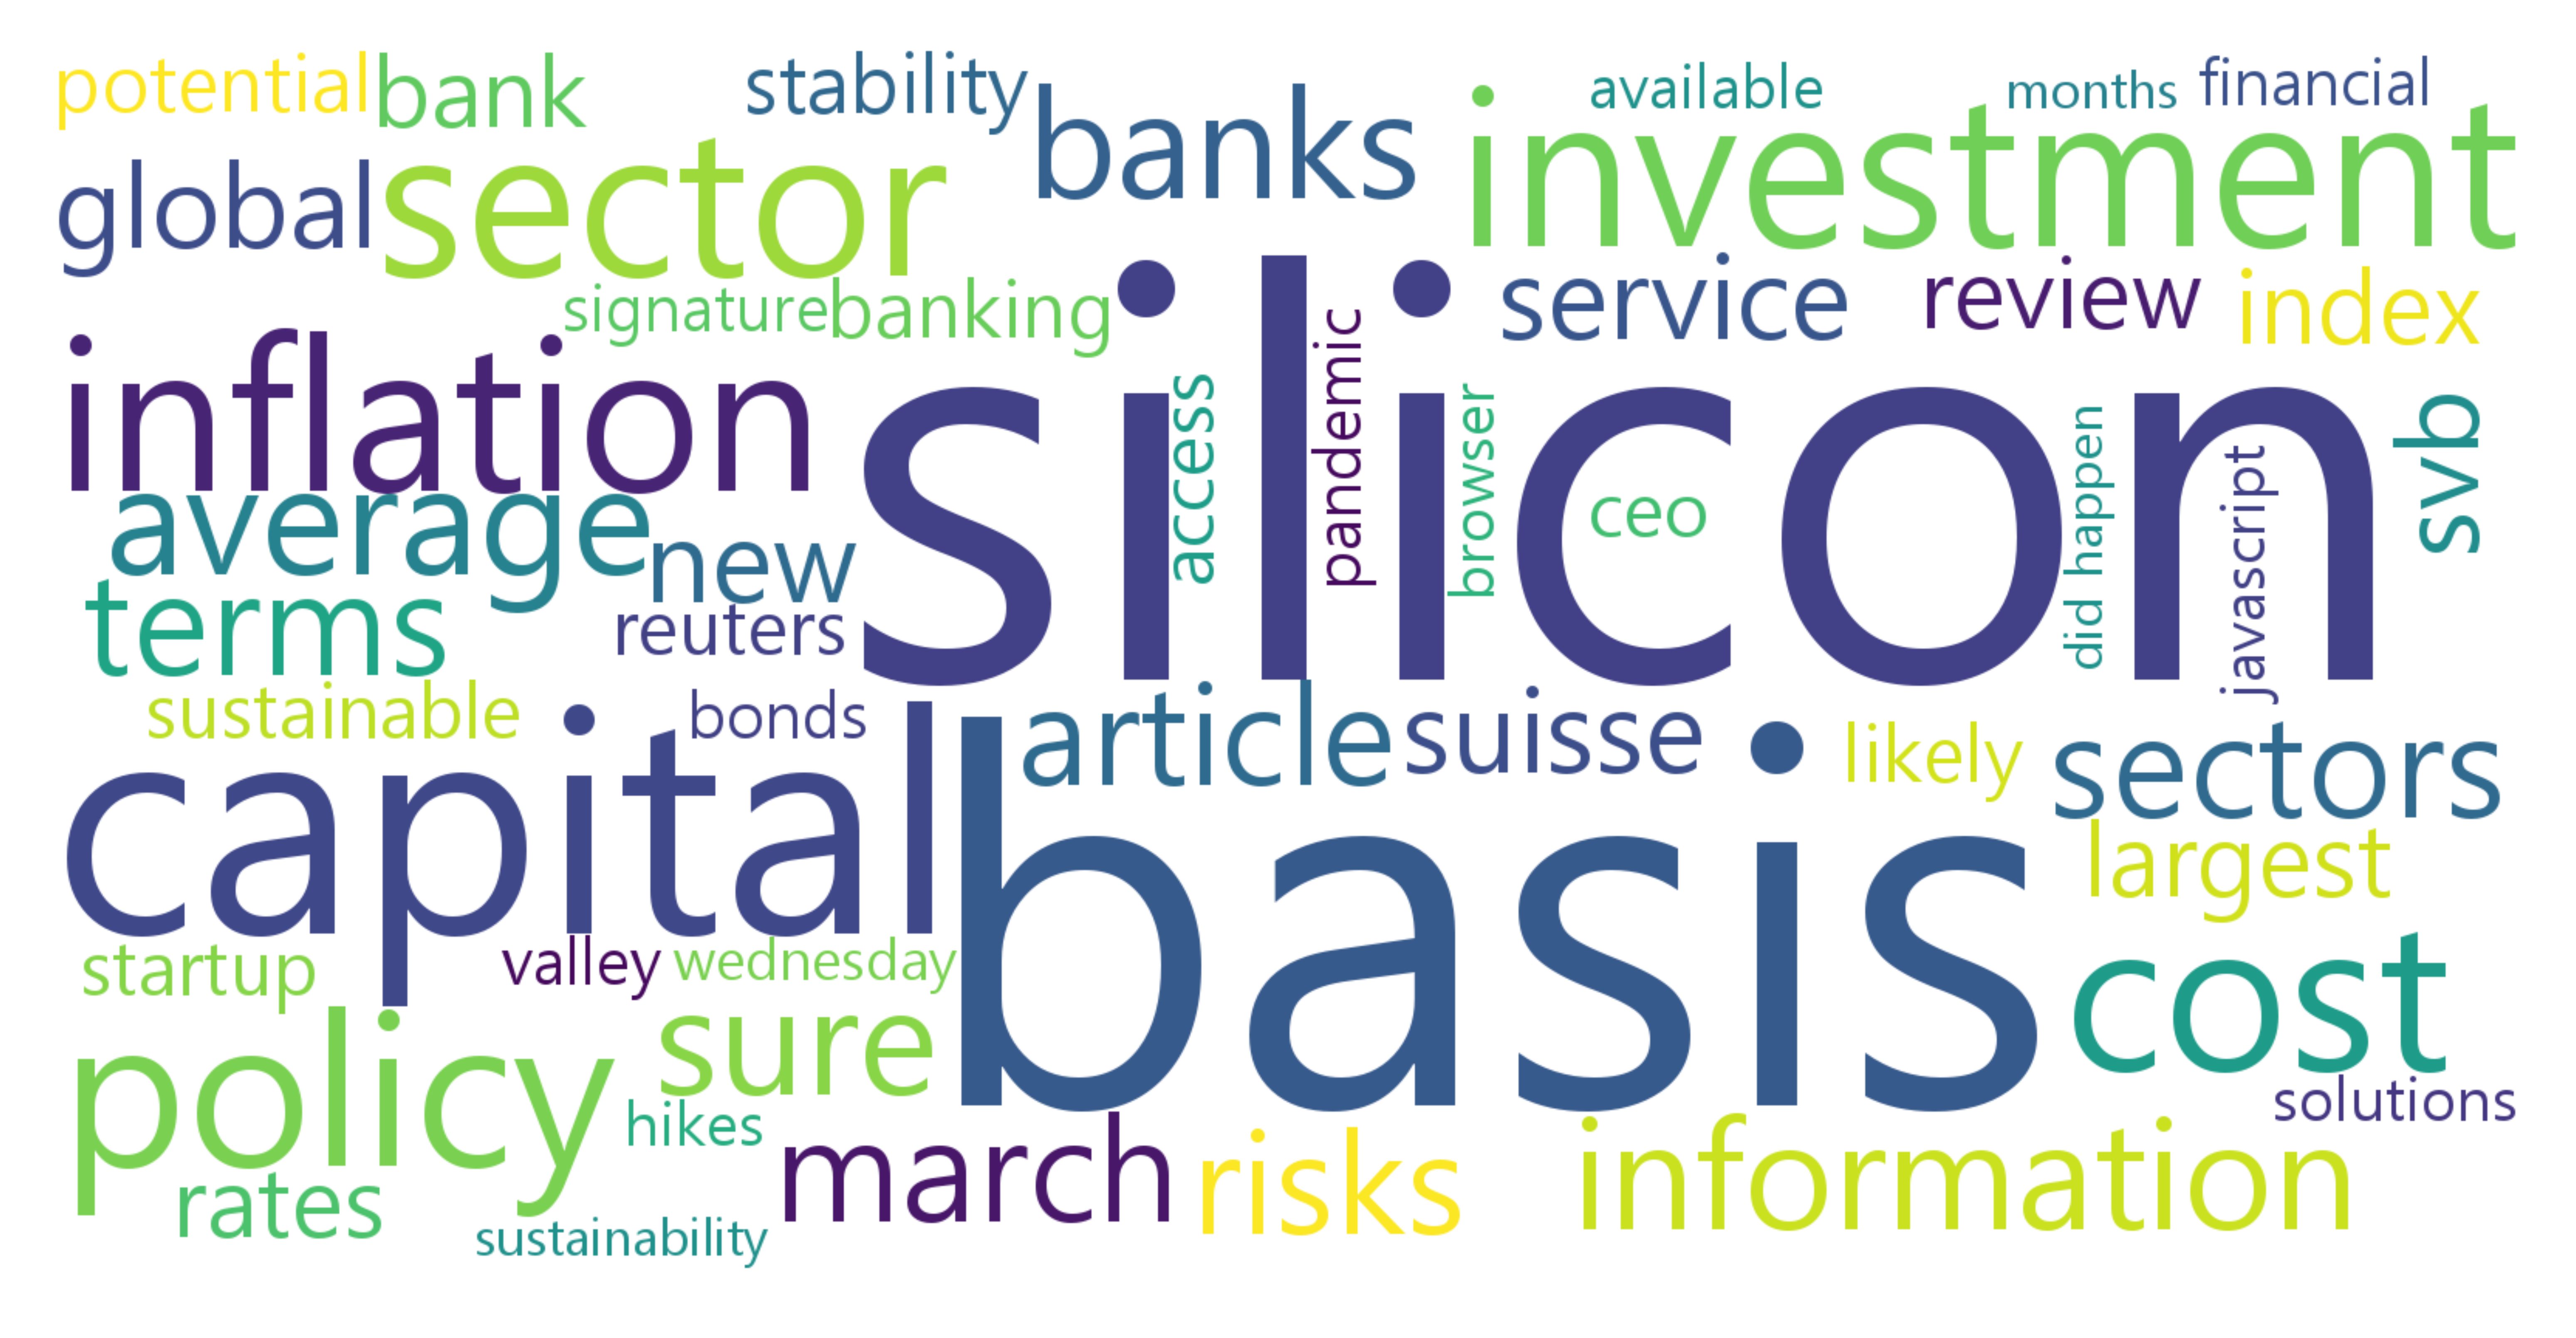

In [27]:
# 그림 그리기 및 저장
print('{}에서 {}까지 키워드 출현 빈도 순 상위 {}개 입니다'.format(from_date,to_date,num_exp))
tags = df_cnt.sort_values(by = 'tot_cnt', ascending = False)[1:num+1]['tot_cnt']
tags = tags.drop(drop_list)
wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800)
# default_color = 'black'
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)

cloud = wc.generate_from_frequencies(dict(tags))
# wc.recolor(color_func=grouped_color_func)

figure(dpi=1200)
title = '대상기간_최대출현_키워드_{}개'.format(str(num))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + topic + '/'+ title + from_date + '.pdf')
plt.show()


In [ ]:
keyword = 'outlook'

In [ ]:
tmp = []
for i in keyword_long_data['키워드']:
    if keyword in i:
        tmp.append(True)
    else:
        tmp.append(False)

for url in url_long_data[tmp]['url']:
    print(url)